## Introduction

### Import Packages

In [1]:
from IPython import display
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, AveragePooling2D, Dropout, BatchNormalization, Embedding
from tensorflow.keras.layers import Flatten, SimpleRNN, LSTM, Conv1D, GRU, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.regularizers import Regularizer, L1, L2
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import zoom
import pandas as pd

### Import Data

In [2]:
with open('time_series_1.pickle', 'rb') as handle:
    time_series_1 = pickle.load(handle).astype('i8')

with open ('time_series_2.pickle', 'rb') as handle:
    time_series_2 = pickle.load(handle).astype('i8')
    
with open ('y.pickle', 'rb') as handle:
    y = pickle.load(handle)

# checking shape of imported data
print(f"Time Series 1 shape: {time_series_1.shape}")
print(f"Time Series 2 shape: {time_series_2.shape}")
print(f"Label Vector shape: {y.shape}")

# check if labels are balanced
print(f"Number of unique Labels: {np.unique(y, return_counts=True)}")

Time Series 1 shape: (4000, 5000)
Time Series 2 shape: (4000, 5000)
Label Vector shape: (4000,)
Number of unique Labels: (array([0., 1., 2., 3.]), array([1000, 1000, 1000, 1000], dtype=int64))


### Pre-Processing and EDA

#### Scaling

The range of sensor readings from both time series are between 0 and 255, hence scaling (normalization) is unnecessary.

In [3]:
# explore range of both time series
print("Time Series 1 range:", (np.min(time_series_1), np.max(time_series_1)))
print("Time series 2 range:", (np.min(time_series_2), np.max(time_series_2)))

Time Series 1 range: (0, 255)
Time series 2 range: (0, 255)


#### Visualizations

##### Exploring difference in trend between Healthy and Faulty operating modes for a single turbine

Interpretation: According to the plots, there is almost no difference in the general trend between the two operating modes for both the time series.

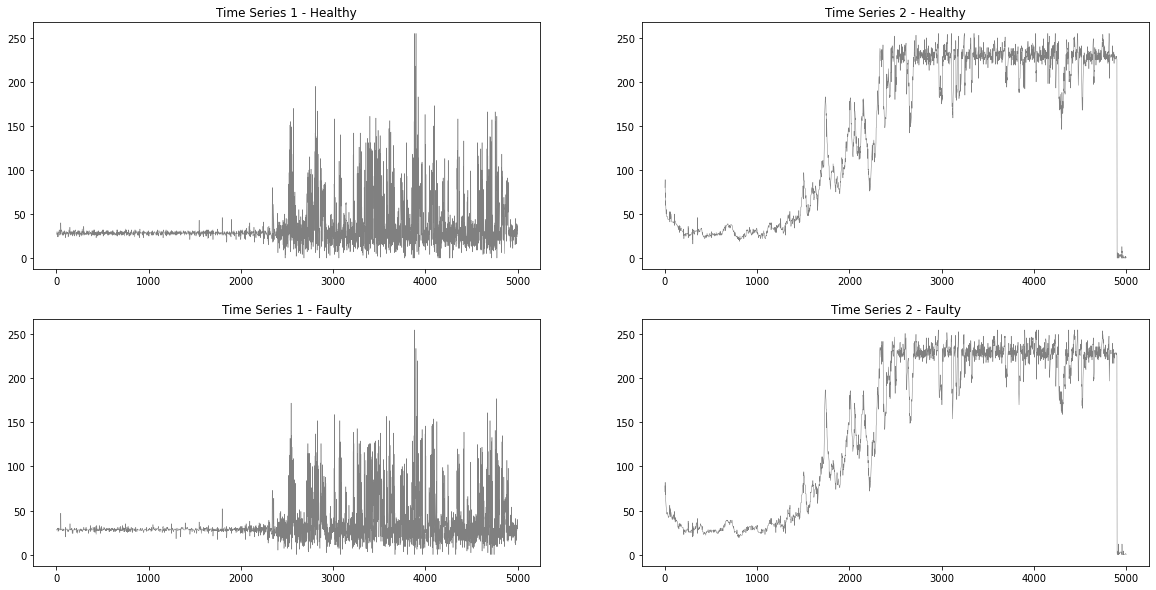

In [4]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax1.title.set_text("Time Series 1 - Healthy")
ax1.plot(time_series_1[np.where((y == 0))[0][0]], linewidth=0.5, color='grey')
ax2 = fig.add_subplot(223)
ax2.title.set_text("Time Series 1 - Faulty")
ax2.plot(time_series_1[np.where((y == 3))[0][0]], linewidth=0.5, color='grey')
ax3 = fig.add_subplot(222)
ax3.title.set_text("Time Series 2 - Healthy")
ax3.plot(time_series_2[np.where((y == 0))[0][0]], linewidth=0.5, color='grey')
ax4 = fig.add_subplot(224)
ax4.title.set_text("Time Series 2 - Faulty")
ax4.plot(time_series_2[np.where((y == 3))[0][0]], linewidth=0.5, color='grey')
plt.show()

##### Exploring difference in peaks and troughs between Healthy and Faulty operating modes for 100 turbines

Interpretation: The peaks and troughs in Time Series 1 seems more prominent for Healthy mode especially when visualizing the last 500 observations, whereas Time Series 2 seems to generally overlap for both operating modes. Therefore, the difference between observations could be feature engineered to capture the difference in peaks and troughs.

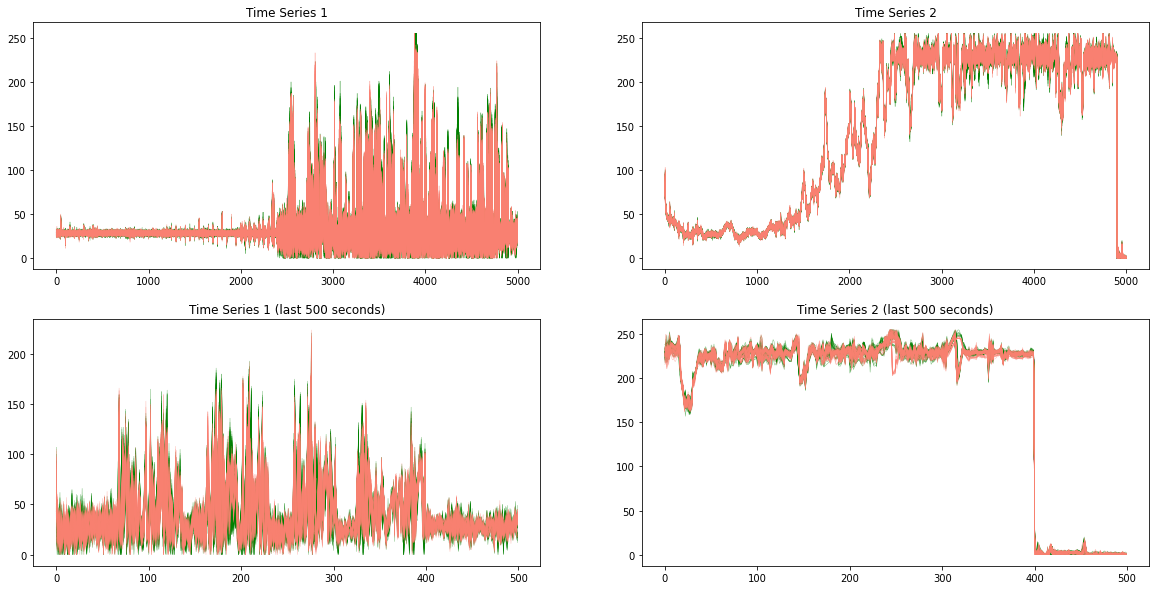

In [5]:
# NOTE: Healthy trend is in GREEN and Faulty trend is in RED
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax1.title.set_text("Time Series 1")
ax1.plot(time_series_1[np.where((y == 0))[0][:100]].T,linewidth=0.5,color='green',label='Healthy',alpha=0.5)
ax1.plot(time_series_1[np.where((y == 3))[0][:100]].T,linewidth=0.5,color='salmon',label='Faulty',alpha=0.5)
ax2 = fig.add_subplot(223)
ax2.title.set_text("Time Series 1 (last 500 seconds)")
ax2.plot(time_series_1[:,-500:][np.where((y == 0))[0][:100]].T,linewidth=0.5,color='green',label='Healthy',alpha=0.5)
ax2.plot(time_series_1[:,-500:][np.where((y == 3))[0][:100]].T,linewidth=0.5,color='salmon',label='Faulty',alpha=0.5)
ax3 = fig.add_subplot(222)
ax3.title.set_text("Time Series 2")
ax3.plot(time_series_2[np.where((y == 0))[0][:100]].T,linewidth=0.5,color='green',label='Healthy',alpha=0.5)
ax3.plot(time_series_2[np.where((y == 3))[0][:100]].T,linewidth=0.5,color='salmon',label='Faulty',alpha=0.5)
ax4 = fig.add_subplot(224)
ax4.title.set_text("Time Series 2 (last 500 seconds)")
ax4.plot(time_series_2[:,-500:][np.where((y == 0))[0][:100]].T,linewidth=0.5,color='green',label='Healthy',alpha=0.5)
ax4.plot(time_series_2[:,-500:][np.where((y == 3))[0][:100]].T,linewidth=0.5,color='salmon',label='Faulty',alpha=0.5)
plt.show()

### Feature Engineering

#### Difference between sensor observations for both time series

The difference between sensor observations for both time series was calculated using `np.diff` and a column of zeros was added to the final observation using `np.zeros` to retain the shape of the time series.

In [6]:
# computing the difference between sensor observations
# a column of zeros is added to the end of each time series to ensure correct shape
time_series_1_diff = np.hstack((np.diff(time_series_1,axis=1), np.zeros((time_series_1.shape[0],1)))) 
time_series_2_diff = np.hstack((np.diff(time_series_2,axis=1), np.zeros((time_series_2.shape[0],1))))
print(time_series_1_diff.shape, time_series_2_diff.shape)

(4000, 5000) (4000, 5000)


Interpretation: The difference in peaks and troughs in both time series are more prominent for both operating modes. Hence, this transformed data could provide a better indication of the difference between operating modes.

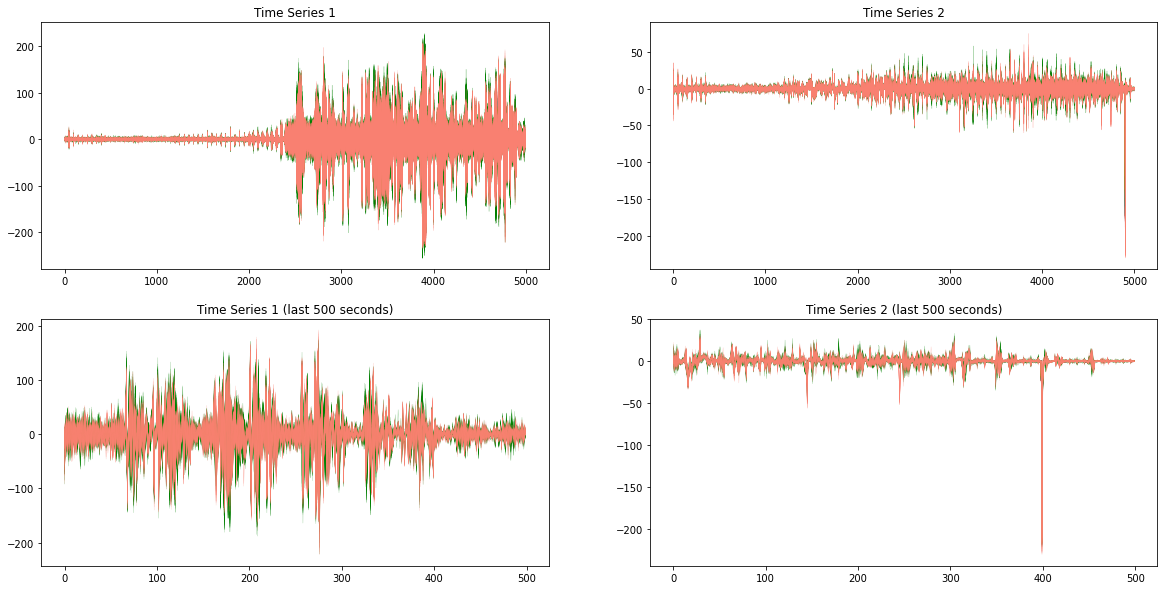

In [7]:
# NOTE: Healthy trend is in GREEN and Faulty trend is in RED
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax1.title.set_text("Time Series 1",)
ax1.plot(time_series_1_diff[np.where((y == 0))[0][:100]].T,linewidth=0.3,color='green',label='Healthy',alpha=0.5)
ax1.plot(time_series_1_diff[np.where((y == 3))[0][:100]].T,linewidth=0.3,color='salmon',label='Faulty',alpha=0.5)
ax2 = fig.add_subplot(222)
ax2.title.set_text("Time Series 2",)
ax2.plot(time_series_2_diff[np.where((y == 0))[0][:100]].T,linewidth=0.3,color='green',label='Healthy',alpha=0.5)
ax2.plot(time_series_2_diff[np.where((y == 3))[0][:100]].T,linewidth=0.3,color='salmon',label='Faulty',alpha=0.5)
ax3 = fig.add_subplot(223)
ax3.title.set_text("Time Series 1 (last 500 seconds)")
ax3.plot(time_series_1_diff[:,-500:][np.where((y == 0))[0][:100]].T,linewidth=0.3,color='green',label='Healthy',alpha=0.5)
ax3.plot(time_series_1_diff[:,-500:][np.where((y == 3))[0][:100]].T,linewidth=0.3,color='salmon',label='Faulty',alpha=0.5)
ax4 = fig.add_subplot(224)
ax4.title.set_text("Time Series 2 (last 500 seconds)")
ax4.plot(time_series_2_diff[:,-500:][np.where((y == 0))[0][:100]].T,linewidth=0.3,color='green',label='Healthy',alpha=0.5)
ax4.plot(time_series_2_diff[:,-500:][np.where((y == 3))[0][:100]].T,linewidth=0.3,color='salmon',label='Faulty',alpha=0.5)
plt.show()

### Custom Function and Helper Variables

In [8]:
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 32
output_result_1 = []
output_result_2 = []
output_result_3 = []
output_result_4 = []
output_result_5 = []

def train_model(model, model_name, X_train, y_train, X_test, y_test, X_val = None, y_val = None, learning_rate = LEARNING_RATE, epochs = EPOCHS, batch_size = BATCH_SIZE):

    np.random.seed(888)
    tf.random.set_seed(888)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

    if X_val is None and y_val is None:
        log = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
        test_result = model.evaluate(X_test, y_test)

        plt.plot(log.history['loss'],label = "training loss")
        plt.legend()
        plt.show()

        output_result = {"model":model_name, "train_loss":log.history['loss'][-1], "val_loss":None, "test_loss":test_result[0], "train_acc":log.history['accuracy'][-1], "val_acc":None, "test_acc":test_result[1]}

    else:  
        log = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), batch_size=batch_size, callbacks = [early_stopping_cb])
        test_result = model.evaluate(X_test, y_test)

        plt.plot(log.history['loss'],label = "training loss")
        plt.plot(log.history['val_loss'], label = "validation loss")
        plt.legend()
        plt.show()
        
        output_result = {"model":model_name, "train_loss":log.history['loss'][-1], "val_loss":log.history['val_loss'][-1], "test_loss":test_result[0], "train_acc":log.history['accuracy'][-1], "val_acc":log.history['val_accuracy'][-1], "test_acc":test_result[1]}

    tf.keras.backend.clear_session()

    return output_result

## Task 1

### Question

_Create a recurrent neural network in TensorFlow to predict the operating mode of a wind turbine based on the two time series from the sensors. Before any implementation, carefully consider what type of approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to manipulate the data, given that you have two different time series for each observation. Then, make sure that you try out the different layers and elements discussed in class, such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be necessary, it is recommended that you tune your network systematically. Make sure to record your final validation set accuracy._

### Answer

The sequence-to-vector approach is the most sensible implementation in this context because a sequence of observations would be the required input for an RNN model with an output vector that carries out multi-classification of the operating mode of the wind turbine (4 classes). Sequence-to-sequence and encoder-decoder approaches are more suitable for machine learning tasks with varying input and output sizes such as speech recognition and translation.

A systematic approach was carried out to select the best RNN model. Firstly, both time series observations from the original data, transformed data (difference between sensor observations), and a combination of original and transformed data were combined using `np.dstack`, then all 3 datasets were split into training (70%), validation (15%) and test (15%) sets prior to training and assessing RNN models.

Due to computational constraint and for consistency, the following parameters were constant:
1. Epochs = 20
2. Learning Rate = 0.001
3. Batch Size = 32
4. Optimizer = Adam
5. Loss Function = sparse_categorical_crossentropy

Next, the original data was utilized to test among SimpleRNN, LSTM and GRU (with 2 layers and 10 neurons) to pick the best out of the 3 models, which resulted in GRU with the highest validation accuracy of ~60%. The original data, transformed data and a combination of original and transformed data were then tested using GRU, which resulted in minimal improvement in accuracy. Hence, the original data alone was utilized for further optimization of GRU.

The following parameters were tuned to optimize the simple GRU model:
1. Increase neurons to 100 for each layer
2. Increase number of layers to 4
3. Add 1 Dropout layer
4. Add convolutional layer

It was observed that increasing the number of neurons and adding convolutional layer resulted in a higher validation accuracy than the simple GRU model (with 2 layers and 10 neurons). Increasing the number of layers to 4 had minimal improvement and increased computational time. Adding 1 Dropout layer made the "optimized" GRU model worse than the simple GRU model. 

After more trial and error the final optimized GRU model had the following structure with 87.5% validation accuracy:

1. One Convolutional layer with 32 filters of size 4 and 2 strides
2. One Convolutional layer with 64 filters of size 4 and 2 strides
3. 2 GRU layers with 100 neurons each
4. 1 Dense layer with 4 neurons and softmax activation

### 1.1 Prepare data to train RNN 

#### 1.1.1 Original Data

In [9]:
# merge time series data into 3D array (time_series_1, time_series_2)  
time_series_ori = np.dstack((time_series_1, time_series_2))
print(time_series_ori.shape)

# split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(time_series_ori, y, test_size=0.3, random_state=888)

# split test data into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=888)

# verify shape of training and validation sets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 5000, 2)
(2800, 5000, 2)
(2800,)
(600, 5000, 2)
(600,)
(600, 5000, 2)
(600,)


#### 1.1.2 Transformed Data - Difference between sensor data

In [18]:
# merge time series data into 3D array (time_series_1, time_series_2)  
time_series_diff = np.dstack((time_series_1_diff, time_series_2_diff))
print(time_series_diff.shape)

# split the data into training and testing sets (70% training, 30% testing)
X_train_diff, X_test_diff, y_train_diff, y_test_diff = train_test_split(time_series_diff, y, test_size=0.3, random_state=888)

# split test data into validation and test sets (50% validation, 50% test)
X_val_diff, X_test_diff, y_val_diff, y_test_diff = train_test_split(X_test_diff, y_test_diff, test_size=0.5, random_state=888)

# verify shape of training and validation sets
print(X_train_diff.shape)
print(y_train_diff.shape)
print(X_val_diff.shape)
print(y_val_diff.shape)
print(X_test_diff.shape)
print(y_test_diff.shape)

(4000, 5000, 2)
(2800, 5000, 2)
(2800,)
(600, 5000, 2)
(600,)
(600, 5000, 2)
(600,)


#### 1.1.3 Stack Original Data and Transformed Data

In [19]:
# merge time series data into 3D array (time_series_1, time_series_2)  
time_series_all = np.dstack((time_series_1, time_series_1_diff, time_series_2, time_series_2_diff))
print(time_series_all.shape)

# split the data into training and testing sets (70% training, 30% testing)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(time_series_all, y, test_size=0.3, random_state=888)

# split test data into validation and test sets (50% validation, 50% test)
X_val_all, X_test_all, y_val_all, y_test_all = train_test_split(X_test_all, y_test_all, test_size=0.5, random_state=888)

# verify shape of training and validation sets
print(X_train_all.shape)
print(y_train_all.shape)
print(X_val_all.shape)
print(y_val_all.shape)
print(X_test_all.shape)
print(y_test_all.shape)

(4000, 5000, 4)
(2800, 5000, 4)
(2800,)
(600, 5000, 4)
(600,)
(600, 5000, 4)
(600,)


### 1.2 Simple RNN Models

Assessing the performance of simple RNN models on the original data

#### 1.2.1 SimpleRNN

In [25]:
# simple RNN model with 2 hidden layers and 10 neurons per layer
simple_RNN_model = Sequential([
    SimpleRNN(10, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(10),
    Dense(4, activation='softmax')
])
simple_RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 10)          130       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 384
Trainable params: 384
Non-trainable params: 0
_________________________________________________________________


In [66]:
# # NOTE: uncomment to train the model
# simple_RNN_model_result = train_model(simple_RNN_model, "simple_RNN_model", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_1.append(simple_RNN_model_result)

#### 1.2.2 LSTM

In [67]:
# LSTM model with 2 hidden layers and 10 neurons per layer
simple_LSTM_model = Sequential([
    LSTM(10, return_sequences=True, input_shape=[None, 2]),
    LSTM(10),
    Dense(4, activation = "softmax")
])
simple_LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 10)          520       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
88/88 [==============================] - 26s 276ms/step - loss: 1.3877 - accuracy: 0.2543 - val_loss: 1.3945 - val_accuracy: 0.2467
Epoch 2/20
88/88 [==============================] - 24s 274ms/step - loss: 1.3874 - accuracy: 0.2539 - val_loss: 1.3801 - val_accuracy: 0.3017
Epoch 3/20
88/88 [==============================] - 24s 277ms/step - loss: 1.3805 - accuracy: 0.3064 - val_loss: 1.3724 - val_accuracy: 0.2833
Epoch 4/20
88/88 [==============================] - 24s 273ms/step - loss: 1.3735 - accuracy: 0.3050 - val_loss: 1.3632 - val_accuracy: 0.3417
Epoch 5/20
88/88 [==============================] - 24s 274ms/step - loss: 1.3598 - accuracy: 0.3500 - val_loss: 1.3497 - val_accuracy: 0.3367
Epoch 6/20
88/88 [==============================] - 22s 251ms/step - loss: 1.3458 - accuracy: 0.3475 - val_loss: 1.3317 - val_accuracy: 0.4017
Epoch 7/20
88/88 [==============================] - 22s 249ms/step - loss: 1.3277 - accuracy: 0.3882 - val_loss: 1.3203 - val_accuracy: 0.3833

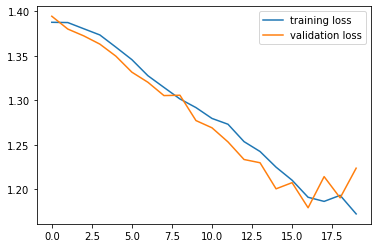

In [64]:
# # NOTE: uncomment to train the model
# simple_LSTM_model_result = train_model(simple_LSTM_model, "simple_LSTM_model", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_1.append(simple_LSTM_model_result)

#### 1.2.3 GRU

In [65]:
# GRU model with 2 hidden layers and 10 neurons per layer
simple_GRU_model = Sequential([
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    GRU(10),
    Dense(4, activation = 'softmax')
])
simple_GRU_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 10)          420       
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 1,124
Trainable params: 1,124
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
88/88 [==============================] - 24s 254ms/step - loss: 1.3814 - accuracy: 0.3039 - val_loss: 1.3696 - val_accuracy: 0.3117
Epoch 2/20
88/88 [==============================] - 22s 249ms/step - loss: 1.3456 - accuracy: 0.3361 - val_loss: 1.3350 - val_accuracy: 0.3650
Epoch 3/20
88/88 [==============================] - 22s 249ms/step - loss: 1.3175 - accuracy: 0.3779 - val_loss: 1.3211 - val_accuracy: 0.3350
Epoch 4/20
88/88 [==============================] - 22s 249ms/step - loss: 1.3027 - accuracy: 0.3779 - val_loss: 1.3013 - val_accuracy: 0.3667
Epoch 5/20
88/88 [==============================] - 22s 251ms/step - loss: 1.2825 - accuracy: 0.3914 - val_loss: 1.2930 - val_accuracy: 0.3967
Epoch 6/20
88/88 [==============================] - 22s 249ms/step - loss: 1.2689 - accuracy: 0.3986 - val_loss: 1.2667 - val_accuracy: 0.3950
Epoch 7/20
88/88 [==============================] - 22s 248ms/step - loss: 1.2552 - accuracy: 0.4079 - val_loss: 1.2590 - val_accuracy: 0.4033

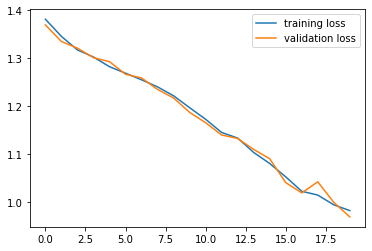

In [66]:
# # NOTE: uncomment to train the model
# simple_GRU_model_result = train_model(simple_GRU_model, "simple_GRU_model", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_1.append(simple_GRU_model_result)

#### 1.2.4 Results

Simple GRU Model is the best with ~60% validation accuracy.

In [65]:
# read data from csv file
output_result_1 = pd.read_csv("output_result_1.csv", index_col=0)
output_result_1

,model,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,simple_RNN_model,1.090300,1.113200,NaN,0.508900,0.510000,NaN
1,simple_LSTM_model,1.172416,1.223814,1.261518,0.486429,0.410000,0.413333
2,simple_GRU_model,0.982359,0.969199,1.006008,0.577857,0.596667,0.561667


### 1.3 Compare Original Data against Transformed Data

Trained with simple GRU model with 20 epochs

#### 1.3.1 Original Data

Epoch 1/20
88/88 [==============================] - 22s 230ms/step - loss: 0.9623 - accuracy: 0.5846 - val_loss: 0.9641 - val_accuracy: 0.5883
Epoch 2/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9585 - accuracy: 0.5886 - val_loss: 0.9596 - val_accuracy: 0.5967
Epoch 3/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9461 - accuracy: 0.5907 - val_loss: 0.9521 - val_accuracy: 0.6033
Epoch 4/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9350 - accuracy: 0.5982 - val_loss: 0.9325 - val_accuracy: 0.6100
Epoch 5/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9315 - accuracy: 0.5950 - val_loss: 0.9425 - val_accuracy: 0.5967
Epoch 6/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9198 - accuracy: 0.6004 - val_loss: 0.9178 - val_accuracy: 0.6067
Epoch 7/20
88/88 [==============================] - 20s 225ms/step - loss: 0.9151 - accuracy: 0.6029 - val_loss: 0.9080 - val_accuracy: 0.6217

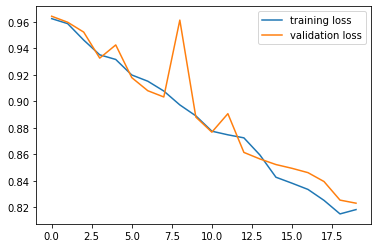

In [70]:
# # NOTE: uncomment to train the model
# simple_GRU_model_ori_data = train_model(simple_GRU_model, "simple_GRU_model_ori_data", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_2.append(simple_GRU_model_ori_data)

#### 1.3.2 Transformed Data - Difference between sensor data

Epoch 1/20
88/88 [==============================] - 22s 229ms/step - loss: 1.5170 - accuracy: 0.2886 - val_loss: 1.3725 - val_accuracy: 0.3317
Epoch 2/20
88/88 [==============================] - 20s 224ms/step - loss: 1.3395 - accuracy: 0.3357 - val_loss: 1.3171 - val_accuracy: 0.3383
Epoch 3/20
88/88 [==============================] - 20s 225ms/step - loss: 1.2888 - accuracy: 0.3814 - val_loss: 1.2790 - val_accuracy: 0.3800
Epoch 4/20
88/88 [==============================] - 20s 225ms/step - loss: 1.2523 - accuracy: 0.4207 - val_loss: 1.2487 - val_accuracy: 0.3833
Epoch 5/20
88/88 [==============================] - 20s 225ms/step - loss: 1.2192 - accuracy: 0.4386 - val_loss: 1.2274 - val_accuracy: 0.3933
Epoch 6/20
88/88 [==============================] - 20s 224ms/step - loss: 1.1910 - accuracy: 0.4504 - val_loss: 1.2006 - val_accuracy: 0.4300
Epoch 7/20
88/88 [==============================] - 20s 224ms/step - loss: 1.1652 - accuracy: 0.4711 - val_loss: 1.1731 - val_accuracy: 0.4317

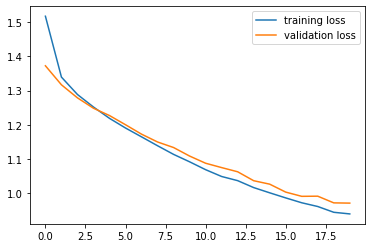

In [71]:
# # NOTE: uncomment to train the model
# simple_GRU_model_diff_data = train_model(simple_GRU_model, "simple_GRU_model_diff_data", X_train = X_train_diff, y_train = y_train_diff, X_test = X_test_diff, y_test = y_test_diff, X_val = X_val_diff, y_val = y_val_diff)
# output_result_2.append(simple_GRU_model_diff_data)

#### 1.3.3 Combine Original Data and Transformed Data

In [72]:
# GRU model with 2 hidden layers and 10 neurons per layer but different input shape
simple_GRU_model = Sequential([
    GRU(10, return_sequences=True, input_shape=[None, 4]),
    GRU(10),
    Dense(4, activation = 'softmax')
])
simple_GRU_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 10)          480       
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 1,184
Trainable params: 1,184
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
88/88 [==============================] - 22s 230ms/step - loss: 1.3837 - accuracy: 0.2786 - val_loss: 1.3715 - val_accuracy: 0.2817
Epoch 2/20
88/88 [==============================] - 20s 225ms/step - loss: 1.3444 - accuracy: 0.3382 - val_loss: 1.3369 - val_accuracy: 0.3283
Epoch 3/20
88/88 [==============================] - 20s 225ms/step - loss: 1.3071 - accuracy: 0.3925 - val_loss: 1.3101 - val_accuracy: 0.3700
Epoch 4/20
88/88 [==============================] - 20s 225ms/step - loss: 1.2740 - accuracy: 0.4007 - val_loss: 1.2566 - val_accuracy: 0.4083
Epoch 5/20
88/88 [==============================] - 20s 225ms/step - loss: 1.2313 - accuracy: 0.4254 - val_loss: 1.2172 - val_accuracy: 0.4283
Epoch 6/20
88/88 [==============================] - 20s 225ms/step - loss: 1.1895 - accuracy: 0.4486 - val_loss: 1.1858 - val_accuracy: 0.4600
Epoch 7/20
88/88 [==============================] - 20s 225ms/step - loss: 1.1634 - accuracy: 0.4700 - val_loss: 1.1610 - val_accuracy: 0.4567

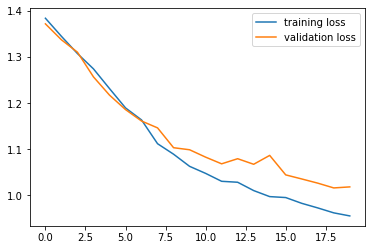

In [73]:
# # NOTE: uncomment to train the model
# simple_GRU_model_all_data = train_model(simple_GRU_model, "simple_GRU_model_all_data", X_train = X_train_all, y_train = y_train_all, X_test = X_test_all, y_test = y_test_all, X_val = X_val_all, y_val = y_val_all)
# output_result_2.append(simple_GRU_model_all_data)

#### 1.3.4 Results

No improvement when using transformed data, hence original data will be used for optimizing GRU model.

In [23]:
# read data from csv file
output_result_2 = pd.read_csv("output_result_2.csv", index_col=0)
output_result_2

,model,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,simple_GRU_model_ori_data,0.818364,0.823192,0.879053,0.658929,0.631667,0.613333
1,simple_GRU_model_diff_data,0.940450,0.971932,0.970821,0.587857,0.576667,0.591667
2,simple_GRU_model_all_data,0.955498,1.018358,0.999841,0.580357,0.521667,0.521667


### 1.4 Optimizing Simple GRU Model

#### 1.4.1 Add Neurons

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 100)         31200     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 92,204
Trainable params: 92,204
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 32s 347ms/step - loss: 1.3594 - accuracy: 0.3246 - val_loss: 1.3069 - val_accuracy: 0.3867
Epoch 2/20
88/88 [==============================] - 30s 342ms/step - loss: 1.2375 - accuracy: 0.4300 - val_loss: 1.2053 - val_accuracy: 0.4333
Epoch 3/20
88/88 [============

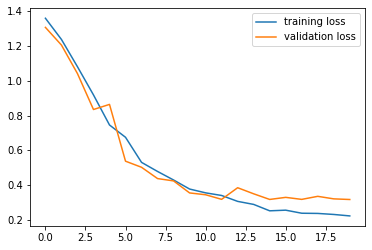

In [75]:
# GRU model with 2 hidden layers and 100 neurons per layer
improved_GRU_model_1 = Sequential([
    GRU(100, return_sequences=True, input_shape=[None, 2]),
    GRU(100),
    Dense(4, activation = 'softmax')
])
improved_GRU_model_1.summary()

In [ ]:
# # NOTE: uncomment to train the model
# improved_GRU_model_1_result = train_model(improved_GRU_model_1, "improved_GRU_model_1", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_3.append(improved_GRU_model_1_result)

#### 1.4.2 Add Layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 10)          420       
                                                                 
 gru_1 (GRU)                 (None, None, 10)          660       
                                                                 
 gru_2 (GRU)                 (None, None, 10)          660       
                                                                 
 gru_3 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 2,444
Trainable params: 2,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 43

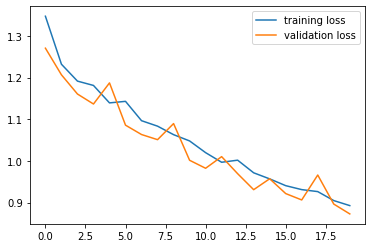

In [76]:
# GRU model with 4 hidden layers and 10 neurons per layer
improved_GRU_model_2 = Sequential([
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    GRU(10),
    Dense(4, activation = 'softmax')
])
improved_GRU_model_2.summary()

In [ ]:
# # NOTE: uncomment to train the model
# improved_GRU_model_2_result = train_model(improved_GRU_model_2, "improved_GRU_model_2", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_3.append(improved_GRU_model_2_result)

#### 1.4.3 Add Dropout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 10)          420       
                                                                 
 dropout (Dropout)           (None, None, 10)          0         
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 1,124
Trainable params: 1,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 22s 231ms/step - loss: 1.4074 - accuracy: 0.2639 - val_loss: 1.3847 - val_accuracy: 0.2617
Epoch 2/20
88/88 [=========================

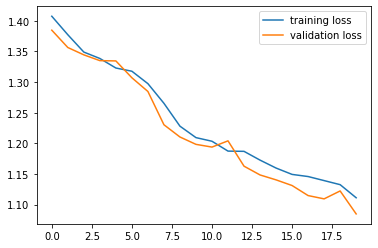

In [77]:
# GRU model with 2 hidden layers and a dropout layer with rate = 0.4
improved_GRU_model_3 = Sequential([
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    Dropout(0.4),
    GRU(10),
    Dense(4, activation = 'softmax')
])
improved_GRU_model_3.summary()

In [ ]:
# # NOTE: uncomment to train the model
# improved_GRU_model_3_result = train_model(improved_GRU_model_3, "improved_GRU_model_3", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_3.append(improved_GRU_model_3_result)

#### 1.4.4 Add Convolution Layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          288       
                                                                 
 gru (GRU)                   (None, None, 10)          1320      
                                                                 
 gru_1 (GRU)                 (None, 10)                660       
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] - 15s 123ms/step - loss: 1.3533 - accuracy: 0.3357 - val_loss: 1.3189 - val_accuracy: 0.3617
Epoch 2/20
88/88 [=========================

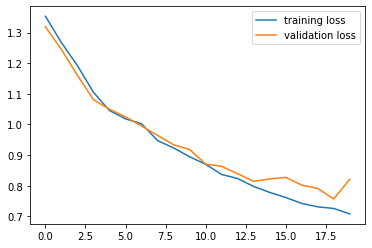

In [78]:
improved_GRU_model_4 = Sequential([
    Conv1D(filters=32, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(10, return_sequences=True, input_shape=[None, 2]),
    GRU(10),
    Dense(4, activation = 'softmax')
])
improved_GRU_model_4.summary()

In [ ]:
# # NOTE: uncomment to train the model
# improved_GRU_model_4_result = train_model(improved_GRU_model_4, "improved_GRU_model_4", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_3.append(improved_GRU_model_4_result)

#### 1.4.5 Final Optimized GRU Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          288       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          8256      
                                                                 
 gru_2 (GRU)                 (None, None, 100)         49800     
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 119,348
Trainable params: 119,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================

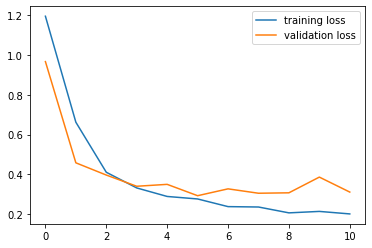

In [26]:
improved_GRU_model_final = Sequential([
    Conv1D(filters=32, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=64, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(100, return_sequences=True, input_shape=[None, 2]),
    GRU(100),
    Dense(4, activation = 'softmax')
])
improved_GRU_model_final.summary()

In [ ]:
# # NOTE: uncomment to train the model
# improved_GRU_model_final_result = train_model(improved_GRU_model_final, "improved_GRU_model_final", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_3.append(improved_GRU_model_final_result)

#### 1.4.6 Results

In [25]:
# read data from csv file
output_result_3 = pd.read_csv("output_result_3.csv", index_col=0)
output_result_3

,model,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,improved_GRU_model_1,0.222994,0.317364,0.342065,0.900000,0.870000,0.858333
1,improved_GRU_model_2,0.892662,0.872698,0.912863,0.619643,0.623333,0.601667
2,improved_GRU_model_3,1.111188,1.084821,1.107201,0.504643,0.508333,0.496667
3,improved_GRU_model_4,0.708120,0.821396,0.820939,0.723929,0.630000,0.641667
4,improved_GRU_model_final,0.180178,0.297278,0.342689,0.913214,0.875000,0.846667


## Task 2

### Question

_Two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 that depict the process of converting one or multiple time series into “images” used within a CNN. In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs_

### Answer

Time series data is a sequence of data that typically contains temporal context where future observations are expected based on past observations. Hence, RNN would be appropriate to model sequences such that each observation can be assumed to be dependent on previous ones, to fully capture temporal context. However, RNNs suffer from vanishing and exploding gradient during back propagation, and training RNNs can be computationally intensive since it has less feature compatibility and has the ability to take arbitrary output or input lengths.

On the other hand, by converting time series data into an image, CNNs could perform better than RNNs. This is because relevant filters can be applied to identify spatial as well as temporal dependencies in images which could sufficiently capture temporal context within the time series. Moreover, CNNs have better computational ability since it takes fixed inputs and provides fixed outputs.

## Task 3

### Question

_Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale image)._

### Answer

In order to train a CNN, the data needs to be in the form of a 3D array such that both sensor data for a single turbine has a shape of (100, 100, 1). This was achieved by reshaping the each time series into a (100, 50, 1) array using `reshape`, then stacking the two time series into a (100, 100, 1) array using `np.concatenate`.

### 3.1 Reshaping Data to train CNN

In [10]:
# reshape train, val, and test data into 100 x 100 x 1
time_series_1_reshape = time_series_1.reshape(4000, 100, 50, 1)
time_series_2_reshape = time_series_2.reshape(4000, 100, 50, 1)
time_series_both_reshape = np.concatenate((time_series_1_reshape, time_series_2_reshape), axis=2)
print(f"The shape of matrix is: {time_series_both_reshape.shape}")

The shape of matrix is: (4000, 100, 100, 1)


### 3.2 Visualizing Reshaped Data

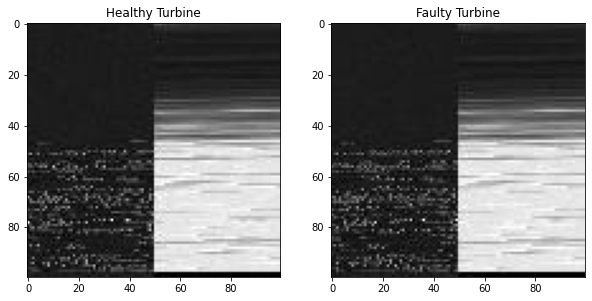

In [28]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.title.set_text("Healthy Turbine")
plt.imshow(time_series_both_reshape[np.where((y == 0))[0][0]], cmap='gray')
ax2 = fig.add_subplot(122)
ax2.title.set_text("Faulty Turbine")
plt.imshow(time_series_both_reshape[np.where((y == 3))[0][0]], cmap='gray')
plt.show()

## Task 4

### Question

_In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy._

### Answer

Based on Figure 12 in the paper, the CNN architecture is as follows:

1. Two Conv2D layers with `32 filters` and `kernel_size = (3, 3)` was added to increase non-linearity.
2. A dropout layer with `rate = 0.2` was added to prevent overfitting by dropping similar neurons.
3. One Conv2D layer with `16 filters`, `kernel_size = (3, 3)` and a `relu` activation function.
4. One MaxPooling2D layer with `pool_size = (3, 3)`.
5. Flattening the output of the last layer with `Flatten()`.
6. One Dense layer with `4 neurons` and `softmax` activation function for multi-classification.

### 4.1 Split Reshaped Data to train CNN

In [29]:
# split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(time_series_both_reshape, y, test_size=0.3, random_state=888)

# split test data into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=888)

print(X_train.shape)
print(y_train.shape)

(2800, 100, 100, 1)
(2800,)


### 4.2 CNN Model from Figure 12 of research paper

In [30]:
# CNN Model from research paper based on Figure 12
CNN_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=[100, 100, 1]),
    Conv2D(32, kernel_size=(3, 3), padding="same"),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(3, 3)),
    Flatten(),
    Dense(4, activation='softmax')
])
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 17424)             0         
                                                        

Epoch 1/20
88/88 [==============================] - 4s 33ms/step - loss: 11.5851 - accuracy: 0.2511 - val_loss: 1.3864 - val_accuracy: 0.2550
Epoch 2/20
88/88 [==============================] - 2s 28ms/step - loss: 1.3829 - accuracy: 0.2746 - val_loss: 1.3865 - val_accuracy: 0.2367
Epoch 3/20
88/88 [==============================] - 2s 26ms/step - loss: 1.3811 - accuracy: 0.2986 - val_loss: 1.3872 - val_accuracy: 0.2367
Epoch 4/20
88/88 [==============================] - 2s 26ms/step - loss: 1.3208 - accuracy: 0.3468 - val_loss: 1.1621 - val_accuracy: 0.5683
Epoch 5/20
88/88 [==============================] - 2s 26ms/step - loss: 0.9150 - accuracy: 0.6146 - val_loss: 0.4472 - val_accuracy: 0.8550
Epoch 6/20
88/88 [==============================] - 2s 26ms/step - loss: 0.4288 - accuracy: 0.8339 - val_loss: 0.2416 - val_accuracy: 0.9083
Epoch 7/20
88/88 [==============================] - 2s 27ms/step - loss: 0.3194 - accuracy: 0.8646 - val_loss: 0.2345 - val_accuracy: 0.9067
Epoch 8/20
8

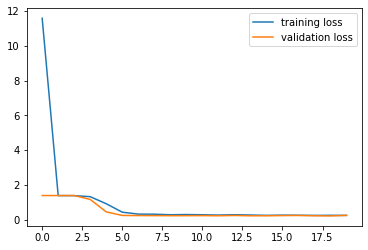

In [31]:
# # NOTE: uncomment to train the model
# CNN_model_result = train_model(CNN_model, "CNN_model", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_4.append(CNN_model_result)

## Task 5

### Question

_Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy._

### Answer

Due to computational constraint and for consistency, the following parameters were constant:
1. Epochs = 20
2. Learning Rate = 0.001
3. Batch Size = 32
4. Optimizer = Adam
5. Loss Function = sparse_categorical_crossentropy

Two approaches were carried out to optimize the CNN model, the first one was to tune the parameters of the CNN model in Task 4 and the second one was to create a CNN model using pre-trained models.

The following parameters were tuned to optimize the CNN model in Task 4:
1. Increase number of filters for the first 2 convolutional layers to 128 and 96 respectively
2. Increase the kernel size of the first convolutional layer to (5,5)
2. Increase strides for all convolutional layers to (2,2)

Prior to traing a pre-trained CNN model, the data was preprocessed to be of shape (224, 224, 3) using `preprocess_input` and `zoom` functions. Multiple pre-trained models were tested such as `MobileNet`, `MobileNetV2` and `ResNet`, but the best pre-trained CNN model was `MobileNet` containing 2 dense layers with 64 and 32 neurons respectively, and 2 dropout layers with rate = 0.2 after the GlobalAveragePooling2D layer.

Results in section 5.3 found that the optimized CNN model from Task 4 performed best with ~91% validation accuracy. 

### 5.1 Add Convolution Layers and Tune parameters

In [32]:
improved_CNN_model_1 = Sequential([
    Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same", input_shape=[100, 100, 1]),
    Conv2D(96, kernel_size=(3, 3), strides=(2, 2), padding="same"),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
    MaxPool2D(pool_size=(3, 3)),
    Flatten(),
    Dense(4, activation='softmax')
])
improved_CNN_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 128)       3328      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 96)        110688    
                                                                 
 dropout (Dropout)           (None, 25, 25, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        13840     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                        

Epoch 1/20
88/88 [==============================] - 2s 22ms/step - loss: 4.0804 - accuracy: 0.3357 - val_loss: 1.2022 - val_accuracy: 0.4317
Epoch 2/20
88/88 [==============================] - 2s 19ms/step - loss: 1.1825 - accuracy: 0.4361 - val_loss: 1.0799 - val_accuracy: 0.5200
Epoch 3/20
88/88 [==============================] - 2s 19ms/step - loss: 1.0817 - accuracy: 0.5025 - val_loss: 0.8493 - val_accuracy: 0.6283
Epoch 4/20
88/88 [==============================] - 2s 19ms/step - loss: 0.6835 - accuracy: 0.7136 - val_loss: 0.4003 - val_accuracy: 0.8467
Epoch 5/20
88/88 [==============================] - 2s 19ms/step - loss: 0.3237 - accuracy: 0.8789 - val_loss: 0.2490 - val_accuracy: 0.9067
Epoch 6/20
88/88 [==============================] - 2s 19ms/step - loss: 0.2671 - accuracy: 0.8904 - val_loss: 0.2241 - val_accuracy: 0.8917
Epoch 7/20
88/88 [==============================] - 2s 19ms/step - loss: 0.2586 - accuracy: 0.8936 - val_loss: 0.2165 - val_accuracy: 0.9083
Epoch 8/20
88

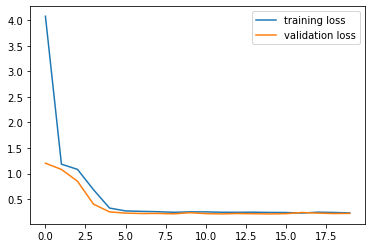

In [33]:
# # NOTE: uncomment to train the model
# improved_CNN_model_1_result = train_model(improved_CNN_model_1, "improved_CNN_model_1", X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, X_val = X_val, y_val = y_val)
# output_result_4.append(improved_CNN_model_1_result)

### 5.2 Integrating Pre-trained Models

#### 5.2.1 Preprocess Data for MobileNet

In [35]:
# converting preprocess train shape by 3
x_preprocess_train = np.repeat(preprocess_input(X_train.copy()), 3, axis=3)
x_preprocess_val = np.repeat(preprocess_input(X_val.copy()), 3, axis=3)
x_preprocess_test = np.repeat(preprocess_input(X_test.copy()), 3, axis=3)

print('Processing training data')
resized_images = []
for i in range(x_preprocess_train.shape[0]):
    resized_images.append(zoom(x_preprocess_train[i], (2.24, 2.24, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_train = np.stack(resized_images)

print('Processing validation data')
resized_images = []
for i in range(x_preprocess_val.shape[0]):
    resized_images.append(zoom(x_preprocess_val[i], (2.24, 2.24, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_val = np.stack(resized_images)

print('Processing testing data')
resized_images = []
for i in range(x_preprocess_test.shape[0]):
    resized_images.append(zoom(x_preprocess_test[i], (2.24, 2.24, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_test = np.stack(resized_images)

# save preprocessed data
pickle.dump(x_preprocess_train, open('x_preprocess_train.pickle', 'wb'))
pickle.dump(x_preprocess_val, open('x_preprocess_val.pickle', 'wb'))
pickle.dump(x_preprocess_test, open('x_preprocess_test.pickle', 'wb'))

In [89]:
# # import preprocessed data
# x_preprocess_train = pickle.load(open('x_preprocess_train.pickle', 'rb'))
# x_preprocess_val = pickle.load(open('x_preprocess_val.pickle', 'rb'))
# x_preprocess_test = pickle.load(open('x_preprocess_test.pickle', 'rb'))
# x_preprocess_train.shape, x_preprocess_val.shape, x_preprocess_test.shape

((2800, 224, 224, 3), (600, 224, 224, 3), (600, 224, 224, 3))

#### 5.2.2 Train MobileNet

In [90]:
# MobileNet CNN model
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (224,224,3))
mobilenet.trainable = False

improved_CNN_model_2 = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])
improved_CNN_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

Epoch 1/20
88/88 [==============================] - 6s 52ms/step - loss: 1.3851 - accuracy: 0.3346 - val_loss: 1.2523 - val_accuracy: 0.4883
Epoch 2/20
88/88 [==============================] - 4s 40ms/step - loss: 1.1778 - accuracy: 0.5064 - val_loss: 0.9846 - val_accuracy: 0.6450
Epoch 3/20
88/88 [==============================] - 4s 41ms/step - loss: 0.9502 - accuracy: 0.6371 - val_loss: 0.8207 - val_accuracy: 0.7383
Epoch 4/20
88/88 [==============================] - 4s 40ms/step - loss: 0.7663 - accuracy: 0.7211 - val_loss: 0.5677 - val_accuracy: 0.8383
Epoch 5/20
88/88 [==============================] - 4s 40ms/step - loss: 0.6012 - accuracy: 0.7768 - val_loss: 0.4408 - val_accuracy: 0.8567
Epoch 6/20
88/88 [==============================] - 4s 40ms/step - loss: 0.5430 - accuracy: 0.7893 - val_loss: 0.4173 - val_accuracy: 0.8783
Epoch 7/20
88/88 [==============================] - 4s 41ms/step - loss: 0.4474 - accuracy: 0.8400 - val_loss: 0.3486 - val_accuracy: 0.8933
Epoch 8/20
88

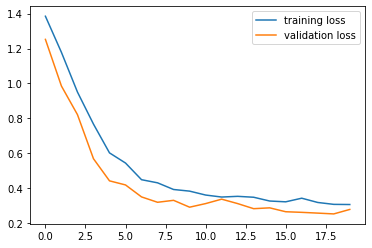

In [91]:
# # NOTE: uncomment to train the model
# improved_CNN_model_2_result = train_model(improved_CNN_model_2, "improved_CNN_model_2", X_train = x_preprocess_train, y_train = y_train, X_test = x_preprocess_test, y_test = y_test, X_val = x_preprocess_val, y_val = y_val)
# output_result_4.append(improved_CNN_model_2_result)

### 5.3 Results

In [70]:
# read data from csv file
output_result_4 = pd.read_csv("output_result_4.csv", index_col=0)
output_result_4

,model,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,CNN_model,0.245048,0.236778,0.269112,0.887500,0.886667,0.855
1,improved_CNN_model_1,0.228001,0.219171,0.233825,0.897857,0.908333,0.890
2,improved_CNN_model_2,0.304964,0.276793,0.285836,0.875000,0.893333,0.875


## Task 6

### Question

_Compare the models you have created so far (both RNNs and CNNs) and make a selection (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set._

### Answer

As observed in the results section below (6.1.3), the CNN model performs better than the RNN model with ~6% higher test accuracy. Moreover, the CNN model only significantly misclassifies Healthy (class 0) turbines as Faulty (class 3) which may be time consuming to physically verify but monetary cost is minimal since the turbine is Healthy in reality. However, the RNN model misclassifies much more Faulty (class 3) turbines as Healthy (class 0) than the CNN model, 70 more misclassifications to be precise. This would be a significant cost to the company and therefore the CNN model would be the better choice.

### 6.1 Compare RNN and CNN

#### 6.1.1 Final Optimized GRU Model (RNN)

In [37]:
# split the data into training and testing sets (70% training, 30% testing)
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = train_test_split(time_series_ori, y, test_size=0.3, random_state=888)

# verify shape of training and validation sets
print(X_train_RNN.shape)
print(y_train_RNN.shape)
print(X_test_RNN.shape)
print(y_test_RNN.shape)

(2800, 5000, 2)
(2800,)
(1200, 5000, 2)
(1200,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          288       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          8256      
                                                                 
 gru (GRU)                   (None, None, 100)         49800     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 119,348
Trainable params: 119,348
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
88/88 [==============================] 

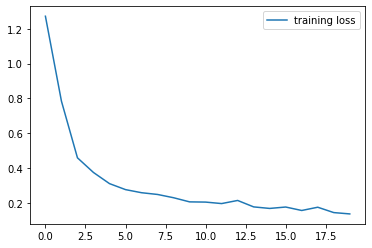

In [43]:
best_RNN_model = Sequential([
    Conv1D(filters=32, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    Conv1D(filters=64, kernel_size=4, strides=2, padding="valid", input_shape=[None, 2]),
    GRU(100, return_sequences=True, input_shape=[None, 2]),
    GRU(100),
    Dense(4, activation = 'softmax')
])
best_RNN_model.summary()

best_RNN_model_result = train_model(best_RNN_model, "best_RNN_model", X_train = X_train_RNN, y_train = y_train_RNN, X_test = X_test_RNN, y_test = y_test_RNN)
# output_result_5.append(best_RNN_model_result)

#### 6.1.2 Improved CNN Model 1

In [11]:
# split the data into training and testing sets (70% training, 30% testing)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(time_series_both_reshape, y, test_size=0.3, random_state=888)

# verify shape of training and validation sets
print(X_train_CNN.shape)
print(y_train_CNN.shape)
print(X_test_CNN.shape)
print(y_test_CNN.shape)

(2800, 100, 100, 1)
(2800,)
(1200, 100, 100, 1)
(1200,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 128)       3328      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 96)        110688    
                                                                 
 dropout (Dropout)           (None, 25, 25, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        13840     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                        

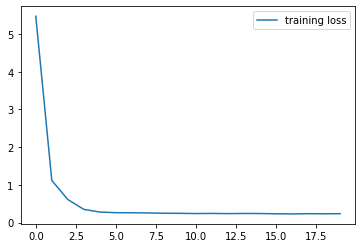

In [12]:
# Convolutional Neural Network
best_CNN_model = Sequential([
    Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same", input_shape=[100, 100, 1]),
    Conv2D(96, kernel_size=(3, 3), strides=(2, 2), padding="same"),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu"),
    MaxPool2D(pool_size=(3, 3)),
    Flatten(),
    Dense(4, activation='softmax')
])
best_CNN_model.summary()

best_CNN_model_result = train_model(best_CNN_model, "best_CNN_model", X_train = X_train_CNN, y_train = y_train_CNN, X_test = X_test_CNN, y_test = y_test_CNN)
# output_result_5.append(best_CNN_model_result)

#### 6.1.3 Results

In [49]:
# read data from csv file
output_result_5 = pd.read_csv("output_result_5.csv", index_col=0)
output_result_5

,model,train_loss,val_loss,test_loss,train_acc,val_acc,test_acc
0,best_RNN_model,0.138570,NaN,0.398157,0.937143,NaN,0.830000
1,best_CNN_model,0.228001,NaN,0.229255,0.897857,NaN,0.898333


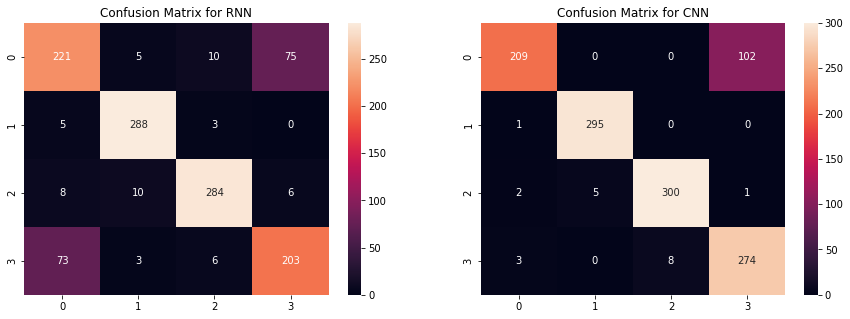

In [69]:
# make predictions with trained RNN and CNN models
y_pred_RNN = best_RNN_model.predict(X_test_RNN)
y_pred_CNN = best_CNN_model.predict(X_test_CNN)

# compute and plot confusion matrix
cm_RNN = confusion_matrix(y_test_RNN, y_pred_RNN.argmax(axis=1))
cm_CNN = confusion_matrix(y_test_CNN, y_pred_CNN.argmax(axis=1))

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
plt.title('Confusion Matrix for RNN')
sns.heatmap(cm_RNN, annot=True, fmt='d', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
ax2 = fig.add_subplot(122)
plt.title('Confusion Matrix for CNN')
sns.heatmap(cm_CNN, annot=True, fmt='d', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])
plt.show()

### 6.2 Save chosen model as .h5-file

In [14]:
# best_CNN_model.save("task_6_model.h5")

In [15]:
best_CNN_model = tf.keras.models.load_model("task_6_model.h5")
best_CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 128)       3328      
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 96)        110688    
                                                                 
 dropout (Dropout)           (None, 25, 25, 96)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        13840     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                        